# Enter your name and student ID number in this box.

TOMAR, RITIK, 557603124:


# HW 3: CIFAR-10 Classification: PyTorch Implementation

In this assignment, you will be classifying the contents of the ten types of images in the CIFAR10 dataset. The implementation will be in PyTorch.

THe learning objectives of the assignment are:

    Learn to use the PyTorch ML framework for creating and training deep networks.
    Learn a structured approach to setting up models, training and testing.
    Experiment with and explain different types of regularization in training networks.

In the last section of the assignment, there are questions that you need to answer about model performance and the concepts for characterizing performance. You may answer the questions in the run notebook that you submit or in a separate pdf document. Since much of the model has been created for you, most of the points in the project will come from your answers.

This notebook was beautifully created by TA Mr. Samuel Fanijo with comments and text by Dr. Julie A Dickerson at Iowa State University. 2023.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
# if you have not installed torchvision or it is missing your installation, need to run the following line
!pip3 install torchvision
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

In [ ]:
# Define device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])


## 1.  Function to get training, validation, and test datasets
This function uses the built-in torchvision datasets that includes many of the standard datasets used to compare networks. Please see <a href="<a href="https://pytorch.org/vision/main/datasets.html" target="_blank" rel="noopener">Torchvision Datasets</a> for more information.
    
Data transformations transform and normalize the data for your network.



In [ ]:
# Function to get training, validation, and test datasets
def get_datasets(transform, batch_size):
    """
    Loads the CIFAR-10 dataset, applies transformations, and splits it into training, validation, and test sets.

    Args:
    - transform: PyTorch transformation to apply to the data.

    Returns:
    - trainloader: DataLoader for the training set.
    - valloader: DataLoader for the validation set.
    - testloader: DataLoader for the test set.
    """
    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Split the training dataset into training and validation
    num_train = len(trainset)
    indices = list(range(num_train))
    split = int(np.floor(0.2 * num_train))

    np.random.seed(42)
    np.random.shuffle(indices)

    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

    # Create data loaders for training, validation, and test
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader, testloader


In [ ]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## 2. Define neural network model
The model set up here is an initial model with three layers. The input layer is size [3072, 512], the hidden layer is [512,256] and the output layer is [256,10]. The activations for the input and hidden layers are the relu function and the output activation will be a softmax function with the cross-entropy loss.

The *init* function defines the layers. The *forward* function defines the forward pass. Note that we are not explicitly adding the softmax function in the output layer. We will instead used the defined function cross-entropy loss that implements both the softmax and the cross-entropy loss.

I strongly suggest that you look at the documentation for the *nn* package in PyTorch to understand the layer types.

In [ ]:
# Define fully connected neural network model
class FCNet(nn.Module):
    """
    A fully connected neural network model for image classification on the CIFAR-10 dataset.

    Architecture:
    - Input: Flattened feature vectors of size 3*32*32
    - Fully Connected Layer 1: 3*32*32 to 512 neurons with ReLU activation
    - Fully Connected Layer 2: 512 to 256 neurons with ReLU activation
    - Fully Connected Layer 3: 256 to 10 output neurons (for 10 classes)

    This network is designed for image classification task with the input data as
    flattened feature vectors. It uses densely connected layers (fully connected layers)
    with ReLU activations to learn the spatial features and relationships in the data.

    Attributes:
    - fc1: First fully connected layer.
    - fc2: Second fully connected layer.
    - fc3: Output layer with 10 classes for CIFAR-10.

    Methods:
    - forward(x): Defines the forward pass of the network.
    """

    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Input size 3*32*32, output size 512
        self.fc2 = nn.Linear(512, 256)  # Hidden layer with 256 neurons
        self.fc3 = nn.Linear(256, 10)  # Output layer with 10 classes

    def forward(self, x):
        """
        Defines the forward pass of the fully connected neural network.

        Args:
        - x: Input feature vector (flattened image).

        Returns:
        - x: Output tensor representing class scores.
        """
        x = x.view(-1, 3 * 32 * 32)  # Flatten the input tensor into a vector
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second layer
        x = self.fc3(x)  # Output layer
        return x


## 3. Function to train the neural network using training set
The functions below use the data loader capabilities to train your network and check the validation and testing data against your trained network. You will not have to make any changes to this function but you should be able to explain how it works.

In [ ]:
# Function to train the neural network using training set
def train_model(model, trainloader, optimizer, criterion, device):
    """
    Trains the neural network on the training dataset.

    Args:
    - model: PyTorch neural network model.
    - trainloader: DataLoader for the training set.
    - optimizer: PyTorch optimizer.
    - criterion: Loss function.
    - device: Device to run the training on (CPU or GPU).

    Returns:
    - train_loss: Average training loss for the epoch.
    - train_accuracy: Training accuracy for the epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients to avoid accumulation

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()  # Accumulate the loss

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    return running_loss / len(trainloader), train_accuracy

### Function to validate the neural network using validation set

In [ ]:
# Function to validate the neural network using validation set
def validate_model(model, valloader, device):
    """
    Validates the neural network on the validation dataset.

    Args:
    - model: PyTorch neural network model.
    - valloader: DataLoader for the validation set.
    - device: Device to run the validation on (CPU or GPU).

    Returns:
    - val_accuracy: Validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    return val_accuracy


### Function to test the model using test set

In [ ]:
# Function to test the neural network using test set
def test_model(model, testloader, device):
    """
    Tests the trained neural network on the test dataset.

    Args:
    - model: PyTorch neural network model.
    - testloader: DataLoader for the test set.
    - device: Device to run the testing on (CPU or GPU).

    Returns:
    - test_accuracy: Test accuracy.
    - true_labels: True labels of test samples.
    - predicted_labels: Predicted labels by the model.
    """
    model.eval()
    correct_test = 0
    total_test = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct_test / total_test

    return test_accuracy, true_labels, predicted_labels

## 4. Define optimizer
In this function, you will need to select which optimizer to use. We have given you 2 different examples. PyTorch has multiple optimizers defined in the [torch.optim](/https://pytorch.org/docs/stable/optim.html) package. You will need to implement two different options from the extensive list of functions and discuss the results

In [ ]:
# Function to select an optimizer
def select_optimizer(optimizer_option, model):
    """
    Define an optimizer for training.

    Returns:
    - optimizer: PyTorch optimizer.
    """
    if optimizer_option == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_option == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif optimizer_option == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    else:
        raise ValueError("Invalid optimizer option")

    return optimizer

### 5. Main: putting everything together
When you run this block, it will ask you to enter in the batch size (try 32, 64 or 128) and which optimizer to use at the bottom (this is hard-coded and you will replace the value). You can also set the number of epochs to train over in the main function.

In [ ]:
# Main function to run the deep learning pipeline
def main(optimizer_option, batch_size, num_epochs):
    """
    Main function to run the model with specified optimizer.

    Args:
    - optimizer_option (may or may not be hardcoded)
    - batch size for training.
    """

    ##################### Define run parameters #########################################
    # Get datasets
    trainloader, valloader, testloader = get_datasets(transform, batch_size)

    # Initialize the model
    model = FCNet().to(device)

    # Select optimizer based on user's choice
    optimizer = select_optimizer(optimizer_option, model)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store training and validation accuracy
    train_accuracy_list = []
    val_accuracy_list = []

    # Set Number of epochs to train model for
    # num_epochs = 10
    #======================
    # Changed to input variable
    #======================
    num_epochs = num_epochs

    ####################################################################################


    # Train the model for multiple epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, trainloader, optimizer, criterion, device)
        val_accuracy = validate_model(model, valloader, device)

        # Append accuracy values to lists for later plotting
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%')

    print('Finished Training')

    # Test the model
    test_accuracy, true_labels, predicted_labels = test_model(model, testloader, device)

    print(f'Test Accuracy: {test_accuracy}%')

    # Calculate classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Unnormalized)')

    # Plot normalized confusion matrix
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.subplot(1, 2, 2)
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.show()

    # Randomly select 10 samples for testing
    print("")
    print("Randomly Select 10 Samples for Testing:")
    random_indices = random.sample(range(len(testloader.dataset)), 10)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        image, label = testloader.dataset[idx]
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        actual_label = class_names[label]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()

Epoch 1, Loss: 1.945757185459137, Training Accuracy: 31.6925%, Validation Accuracy: 38.02%
Epoch 2, Loss: 1.658185771560669, Training Accuracy: 41.6775%, Validation Accuracy: 42.37%
Epoch 3, Loss: 1.54290764837265, Training Accuracy: 46.0225%, Validation Accuracy: 45.34%
Epoch 4, Loss: 1.459636686706543, Training Accuracy: 48.7225%, Validation Accuracy: 47.9%
Epoch 5, Loss: 1.391247880744934, Training Accuracy: 51.34%, Validation Accuracy: 49.78%
Epoch 6, Loss: 1.3310574447155, Training Accuracy: 53.305%, Validation Accuracy: 51.33%
Epoch 7, Loss: 1.27655435423851, Training Accuracy: 55.27%, Validation Accuracy: 51.35%
Epoch 8, Loss: 1.2268301361083984, Training Accuracy: 57.3375%, Validation Accuracy: 52.2%
Epoch 9, Loss: 1.177160193157196, Training Accuracy: 58.79%, Validation Accuracy: 52.16%
Epoch 10, Loss: 1.1295995094776154, Training Accuracy: 60.4075%, Validation Accuracy: 52.71%
Finished Training
Test Accuracy: 52.14%
              precision    recall  f1-score   support

    a

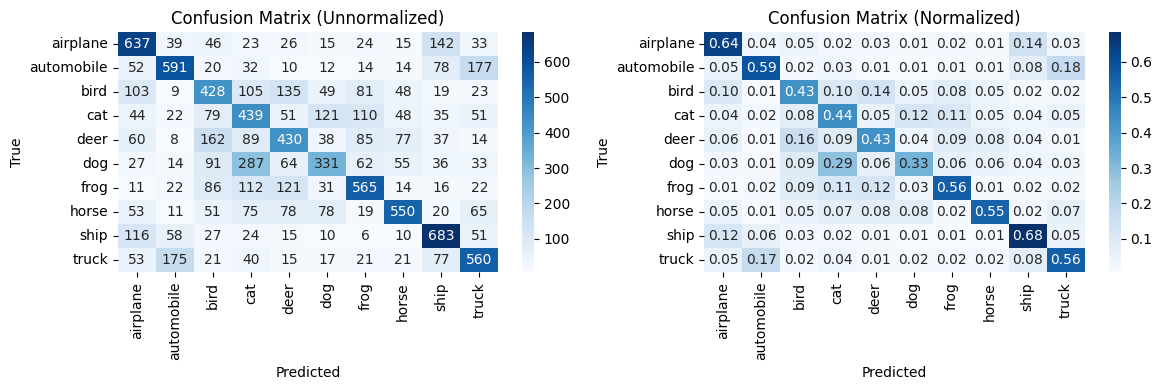


Randomly Select 10 Samples for Testing:


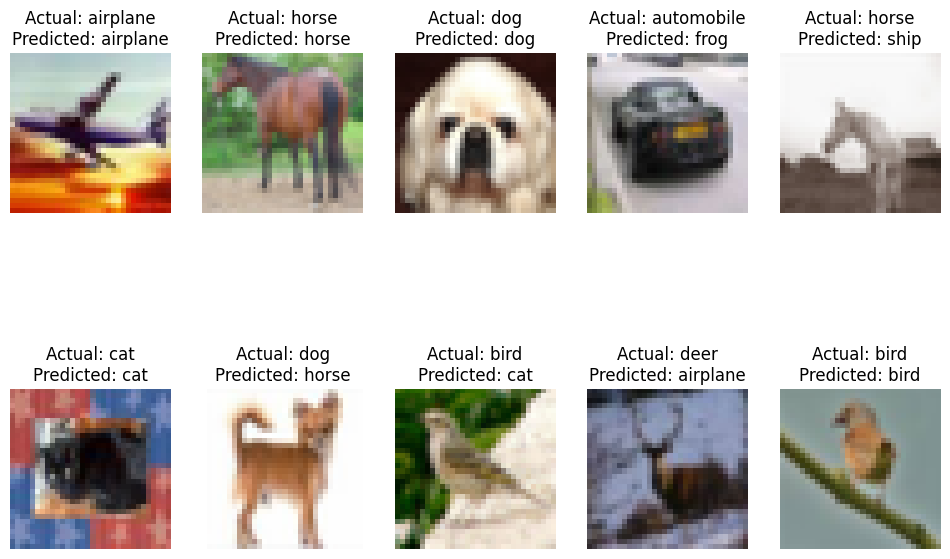

In [ ]:
if __name__ == "__main__":
    # Select the optimizer option
    #optimizer_option = input("Select optimizer option (adam,  momentum, SGD): ")
    optimizer_option = "SGD" #changed to an hardcoded version
    # Select the batch size for training
    # batch_size = int(input("Enter batch size: "))
    batch_size = 32 #changed to an hardcoded version
    num_epochs = 10
    main(optimizer_option, batch_size, num_epochs)

Epoch 1, Loss: 1.6798451334476472, Training Accuracy: 40.145%, Validation Accuracy: 42.97%
Epoch 2, Loss: 1.4850707173347473, Training Accuracy: 47.2225%, Validation Accuracy: 47.0%
Epoch 3, Loss: 1.3715577555179597, Training Accuracy: 51.54%, Validation Accuracy: 47.7%
Epoch 4, Loss: 1.2859353174209596, Training Accuracy: 54.0675%, Validation Accuracy: 50.61%
Epoch 5, Loss: 1.205691156768799, Training Accuracy: 57.14%, Validation Accuracy: 49.83%
Epoch 6, Loss: 1.1260244581699372, Training Accuracy: 59.74%, Validation Accuracy: 50.62%
Epoch 7, Loss: 1.057051941728592, Training Accuracy: 62.6025%, Validation Accuracy: 50.19%
Epoch 8, Loss: 0.9915806030988693, Training Accuracy: 64.805%, Validation Accuracy: 50.16%
Epoch 9, Loss: 0.9240807295322419, Training Accuracy: 67.0525%, Validation Accuracy: 50.75%
Epoch 10, Loss: 0.8601617338657379, Training Accuracy: 69.4575%, Validation Accuracy: 51.0%
Finished Training
Test Accuracy: 51.53%
              precision    recall  f1-score   suppor

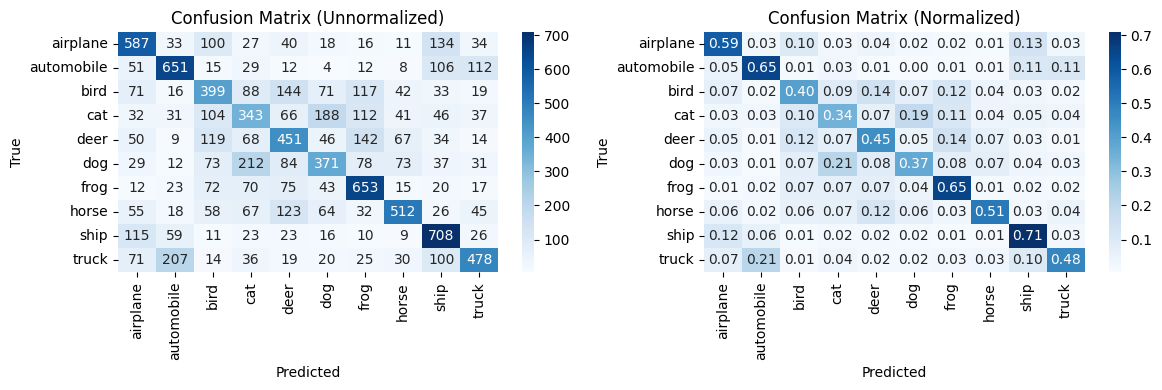


Randomly Select 10 Samples for Testing:


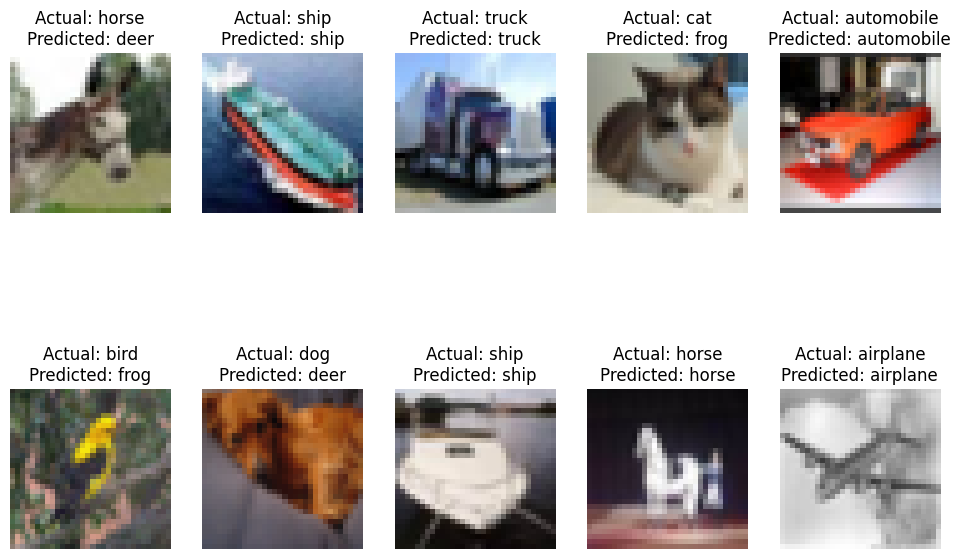

In [ ]:
# Case-1: Changed optimizer to adam
if __name__ == "__main__":
    # Select the optimizer option
    #optimizer_option = input("Select optimizer option (adam,  momentum, SGD): ")
    optimizer_option = "adam" #changed to an hardcoded version
    # Select the batch size for training
    # batch_size = int(input("Enter batch size: "))
    batch_size = 32 #changed to an hardcoded version
    num_epochs = 10
    main(optimizer_option, batch_size, num_epochs)

New Code scripts  

New Neural Net  

Improved Main Function

**2 Added dynamic layers and new hyperparameters to the provided neural network model.**

 I considered creating a general FCNet model with dynamic hidden layers, dimensions, activation functions, and batch normalization after conducting a number of trials.  This is my updated FCNet model codeset.

In [ ]:
class FCNet(nn.Module):
    """
    A flexible fully connected neural network model with input flattening and dynamic layers.

    Attributes:
    - input_dim: Input dimension for the feature vector.
    - hidden_dims: List of dimensions for hidden layers.
    - activations: List of activation functions for each hidden layer.
    - output_dim: Output dimension (number of classes).

    Methods:
    - __init__(input_dim, hidden_dims, activations, output_dim): Initializes the model.
    - forward(x): Defines the forward pass of the network.
    """

    def __init__(self, input_dim, hidden_dims, activations, output_dim):
        super(FCNet, self).__init__()

        # Check if the number of hidden layers, dimensions, and activations match
        if len(hidden_dims) != len(activations):
            raise ValueError("Number of hidden layers must match the number of activation functions.")

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.activations = activations

        # Create the input layer
        self.layers = [nn.Linear(input_dim, hidden_dims[0])]
        self.layers.append(nn.BatchNorm1d(hidden_dims[0]))  # Batch normalization
        self.layers.append(activations[0])

        # Create hidden layers with specified dimensions and activations
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            self.layers.append(nn.BatchNorm1d(hidden_dims[i]))  # Batch normalization
            self.layers.append(activations[i])

        # Create the output layer
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))

        # Define the model using nn.Sequential
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        """
        Defines the forward pass of the fully connected neural network.

        Args:
        - x: Input feature vector.

        Returns:
        - x: Output tensor representing class scores.
        """
        x = x.view(-1, self.input_dim)  # Flatten the input tensor into a vector
        return self.model(x)

**4[Added new optimizers and updated] the provided optimizer with weidgt_decay**

 From the torch.optim library, I have included two additional optimizers: rmsprop and adagrad.  Additionally, I have included the weight_decay optimizer, which is a popular method of preventing overfitting by including a regularization term in the loss function.  This is the most recent code script.

In [ ]:
# Function to select an optimizer
def select_optimizer(optimizer_option, model, learning_rate):
    """
    Define an optimizer for training.
    Adding weight decay to an optimizer is a common technique to prevent overfitting by adding a regularization term to the loss function.
    Here, I added weight decay (5e-4) to the optimizers, which is generally a reasonable practice.
    However, it's important to be aware of how weight decay works and to choose an appropriate value for the specific problem.

    Returns:
    - optimizer: PyTorch optimizer.


    """
    if optimizer_option == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    elif optimizer_option == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    elif optimizer_option == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    #======================
    # Added rmsprop and adagrad Algorithms from torch.optim package: https://pytorch.org/docs/stable/optim.html
    #======================
    elif optimizer_option == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.9, weight_decay=5e-4)
    elif optimizer_option == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    #======================
    else:
        raise ValueError("Invalid optimizer option")

    return optimizer

**5[Updated] the Scheduler and Main function using my modified FCNet function.**

 I make an effort to maintain the Main's consistency.  I changed it using my scheduler and generic FCNet model.  This is the most recent code script.

In [ ]:
# Main function to run the deep learning pipeline
def main_(optimizer_option, batch_size, num_epochs, input_dim, hidden_dims, activations, output_dim, learning_rate):
    """
    Main function to run the model with specified optimizer.

    Args:
    - optimizer_option (may or may not be hardcoded)
    - batch size for training.
    """

    ##################### Define run parameters #########################################
    # Get datasets
    trainloader, valloader, testloader = get_datasets(transform, batch_size)

    # Initialize the model
    model = FCNet(input_dim, hidden_dims, activations, output_dim).to(device)

    # Select optimizer based on user's choice
    optimizer = select_optimizer(optimizer_option, model, learning_rate)

    # Define the CosineAnnealingLR scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=200)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store training and validation accuracy
    train_accuracy_list = []
    val_accuracy_list = []

    # Set Number of epochs to train model for
    # num_epochs = 10
    #======================
    #======================
    num_epochs = num_epochs

    ####################################################################################

    # Train the model for multiple epochs
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_model(model, trainloader, optimizer, criterion, device)
        val_accuracy = validate_model(model, valloader, device)

        # Append accuracy values to lists for later plotting
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(val_accuracy)

        # Update the learning rate at the end of each epoch
        scheduler.step()

        print(f'Epoch {epoch + 1}, Loss: {train_loss}, Training Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%')

    print('Finished Training')

    # Test the model
    test_accuracy, true_labels, predicted_labels = test_model(model, testloader, device)

    print(f'Test Accuracy: {test_accuracy}%')

    # Calculate classification report
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot unnormalized confusion matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Unnormalized)')

    # Plot normalized confusion matrix
    normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.subplot(1, 2, 2)
    sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Normalized)')
    plt.tight_layout()
    plt.show()

    # Randomly select 10 samples for testing
    print("")
    print("Randomly Select 10 Samples for Testing:")
    random_indices = random.sample(range(len(testloader.dataset)), 10)
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        image, label = testloader.dataset[idx]
        image = image / 2 + 0.5  # Unnormalize
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        actual_label = class_names[label]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
        plt.axis('off')
    plt.show()

{'batch_size': 32, 'num_epochs': 10, 'hidden_dims': [512, 256], 'activations': [ReLU(), ReLU()], 'learning_rate': 0.01, 'optimizer': 'SGD'}
Epoch 1, Loss: 1.6547434215545653, Training Accuracy: 41.615%, Validation Accuracy: 47.62%
Epoch 2, Loss: 1.435744280385971, Training Accuracy: 48.8975%, Validation Accuracy: 50.66%
Epoch 3, Loss: 1.3377147071361541, Training Accuracy: 52.6325%, Validation Accuracy: 51.1%
Epoch 4, Loss: 1.2690514488220215, Training Accuracy: 55.1225%, Validation Accuracy: 51.93%
Epoch 5, Loss: 1.2011853897571563, Training Accuracy: 57.435%, Validation Accuracy: 53.29%
Epoch 6, Loss: 1.143615502166748, Training Accuracy: 59.9325%, Validation Accuracy: 53.8%
Epoch 7, Loss: 1.094268209695816, Training Accuracy: 61.2975%, Validation Accuracy: 53.04%
Epoch 8, Loss: 1.0506571886777878, Training Accuracy: 63.15%, Validation Accuracy: 54.53%
Epoch 9, Loss: 1.0017868999958037, Training Accuracy: 64.8125%, Validation Accuracy: 54.1%
Epoch 10, Loss: 0.9584682283878326, Traini

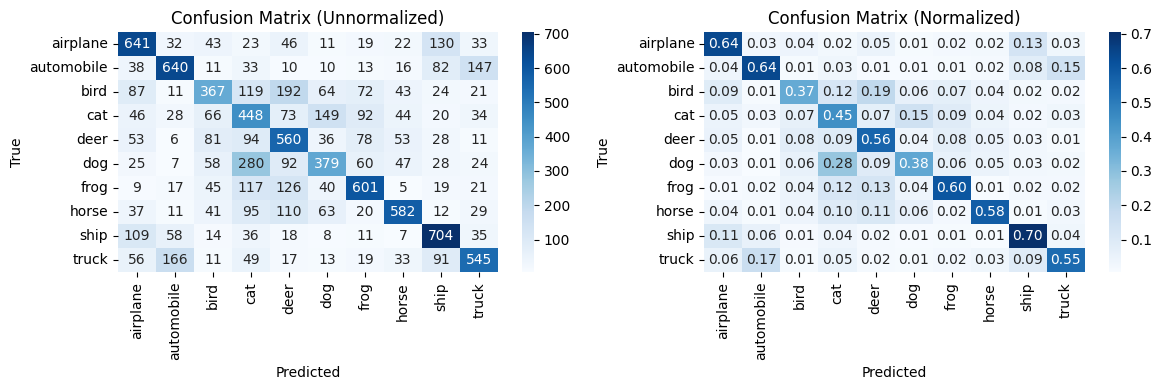


Randomly Select 10 Samples for Testing:


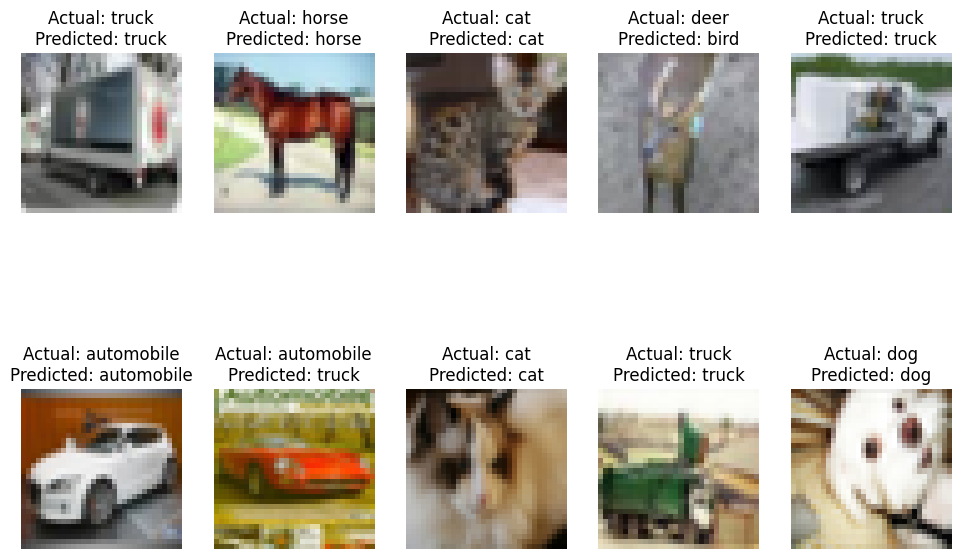

{'batch_size': 32, 'num_epochs': 10, 'hidden_dims': [512, 256], 'activations': [ReLU(), ReLU()], 'learning_rate': 0.01, 'optimizer': 'adam'}
Epoch 1, Loss: 1.8827066562652588, Training Accuracy: 32.0025%, Validation Accuracy: 32.11%
Epoch 2, Loss: 1.805429288005829, Training Accuracy: 35.1725%, Validation Accuracy: 35.19%
Epoch 3, Loss: 1.7893326869964599, Training Accuracy: 35.37%, Validation Accuracy: 34.7%
Epoch 4, Loss: 1.779906682395935, Training Accuracy: 35.745%, Validation Accuracy: 38.6%
Epoch 5, Loss: 1.7680456965446472, Training Accuracy: 36.59%, Validation Accuracy: 37.27%
Epoch 6, Loss: 1.7648674001693725, Training Accuracy: 36.29%, Validation Accuracy: 35.82%
Epoch 7, Loss: 1.7638453501701354, Training Accuracy: 36.4475%, Validation Accuracy: 37.15%
Epoch 8, Loss: 1.7571644500732422, Training Accuracy: 36.695%, Validation Accuracy: 36.95%
Epoch 9, Loss: 1.7553175132751464, Training Accuracy: 36.8025%, Validation Accuracy: 39.28%
Epoch 10, Loss: 1.7517552504539489, Trainin

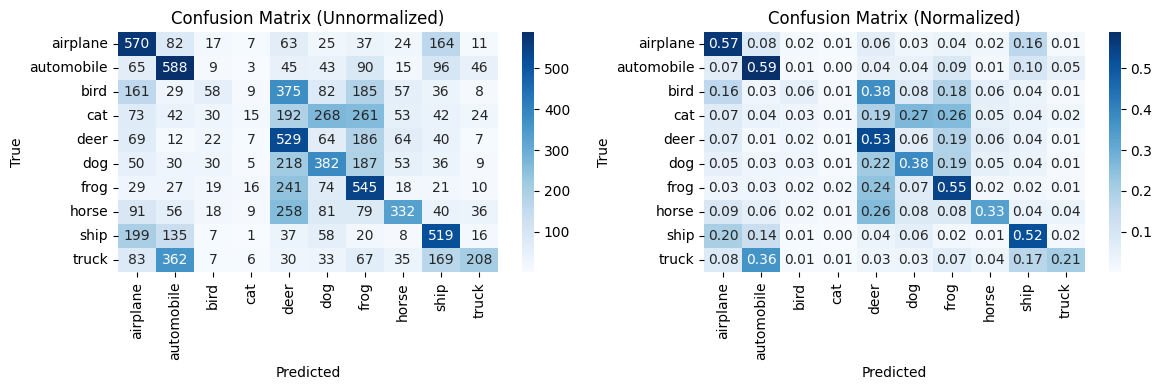


Randomly Select 10 Samples for Testing:


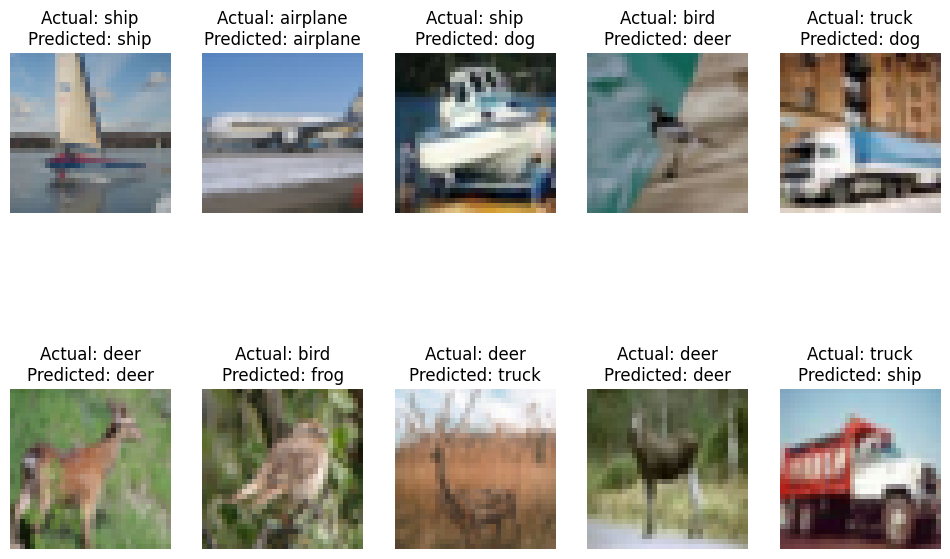

{'batch_size': 32, 'num_epochs': 10, 'hidden_dims': [512, 256], 'activations': [ReLU(), ReLU()], 'learning_rate': 0.001, 'optimizer': 'adam'}
Epoch 1, Loss: 1.6810902073860168, Training Accuracy: 39.5775%, Validation Accuracy: 44.78%
Epoch 2, Loss: 1.5355063548088075, Training Accuracy: 45.0125%, Validation Accuracy: 46.7%
Epoch 3, Loss: 1.4784599388599395, Training Accuracy: 47.095%, Validation Accuracy: 48.2%
Epoch 4, Loss: 1.4379157179832458, Training Accuracy: 48.685%, Validation Accuracy: 49.61%
Epoch 5, Loss: 1.4017169507503509, Training Accuracy: 50.175%, Validation Accuracy: 50.26%
Epoch 6, Loss: 1.3739587561130524, Training Accuracy: 50.8775%, Validation Accuracy: 50.66%
Epoch 7, Loss: 1.3460470587730409, Training Accuracy: 51.7425%, Validation Accuracy: 51.31%
Epoch 8, Loss: 1.3302780141353607, Training Accuracy: 52.565%, Validation Accuracy: 50.26%
Epoch 9, Loss: 1.313618942975998, Training Accuracy: 52.83%, Validation Accuracy: 50.83%
Epoch 10, Loss: 1.2955200159549713, Tra

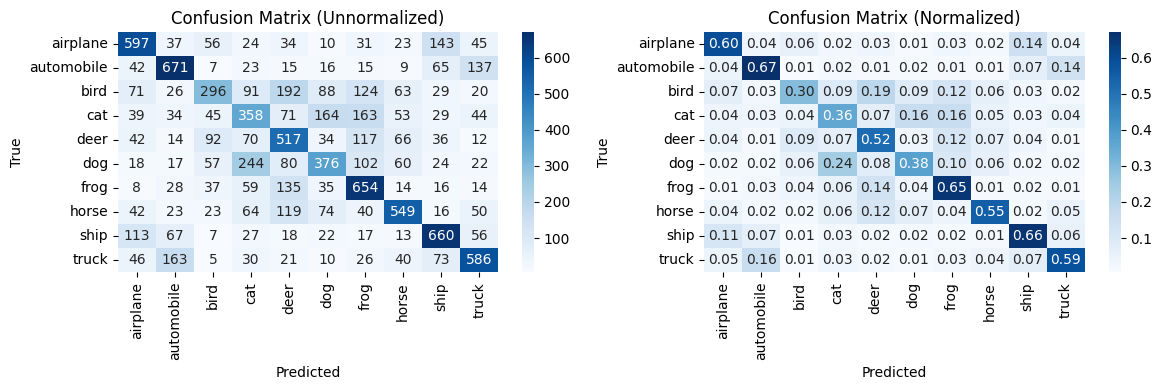


Randomly Select 10 Samples for Testing:


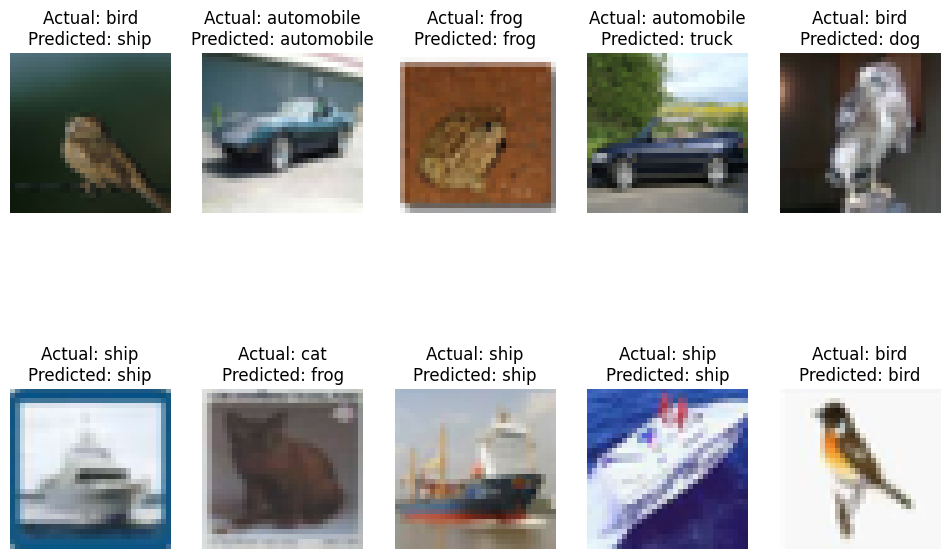

{'batch_size': 32, 'num_epochs': 10, 'hidden_dims': [512, 256, 16], 'activations': [ReLU(), ReLU(), ReLU()], 'learning_rate': 0.01, 'optimizer': 'adam'}
Epoch 1, Loss: 1.900446291065216, Training Accuracy: 30.8375%, Validation Accuracy: 33.36%
Epoch 2, Loss: 1.826979353237152, Training Accuracy: 33.7725%, Validation Accuracy: 34.79%
Epoch 3, Loss: 1.8078277106285094, Training Accuracy: 34.7825%, Validation Accuracy: 36.09%
Epoch 4, Loss: 1.7988853706359864, Training Accuracy: 34.8875%, Validation Accuracy: 34.66%
Epoch 5, Loss: 1.792793425655365, Training Accuracy: 35.455%, Validation Accuracy: 34.66%
Epoch 6, Loss: 1.7895182222366333, Training Accuracy: 35.135%, Validation Accuracy: 36.62%
Epoch 7, Loss: 1.791080488204956, Training Accuracy: 35.53%, Validation Accuracy: 37.21%
Epoch 8, Loss: 1.7874403471946716, Training Accuracy: 35.405%, Validation Accuracy: 35.42%
Epoch 9, Loss: 1.7832710453987122, Training Accuracy: 35.64%, Validation Accuracy: 36.56%
Epoch 10, Loss: 1.784211622714

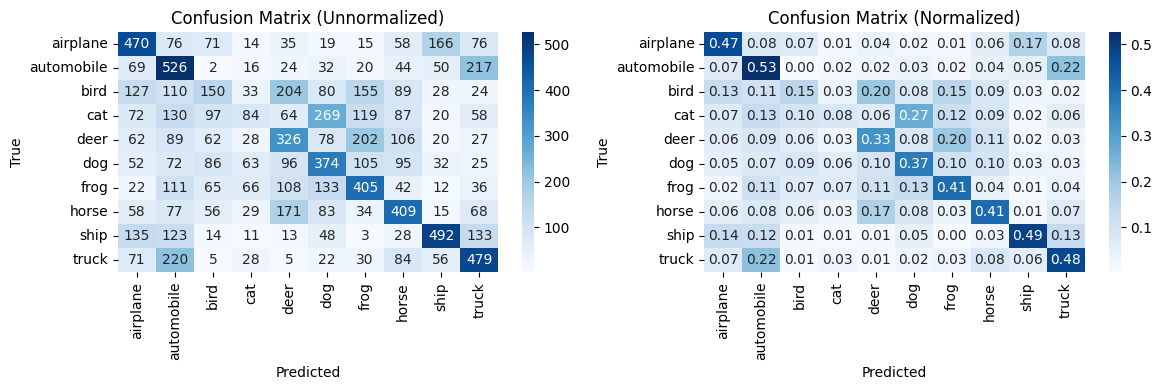


Randomly Select 10 Samples for Testing:


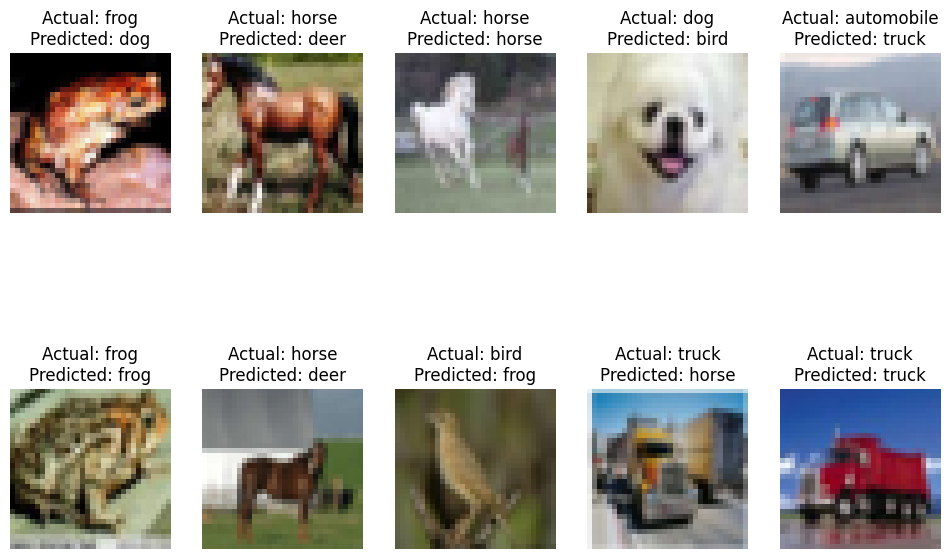

{'batch_size': 32, 'num_epochs': 10, 'hidden_dims': [512, 256, 16], 'activations': [ReLU(), ReLU(), ReLU()], 'learning_rate': 0.01, 'optimizer': 'SGD'}
Epoch 1, Loss: 1.8180365056991576, Training Accuracy: 37.2575%, Validation Accuracy: 44.38%
Epoch 2, Loss: 1.5348254815101623, Training Accuracy: 46.405%, Validation Accuracy: 47.94%
Epoch 3, Loss: 1.4206259279727935, Training Accuracy: 49.9425%, Validation Accuracy: 49.82%
Epoch 4, Loss: 1.3405360949516296, Training Accuracy: 52.9925%, Validation Accuracy: 51.35%
Epoch 5, Loss: 1.275000576686859, Training Accuracy: 54.9325%, Validation Accuracy: 50.95%
Epoch 6, Loss: 1.2177015739440917, Training Accuracy: 57.3425%, Validation Accuracy: 53.1%
Epoch 7, Loss: 1.1710349546909333, Training Accuracy: 58.805%, Validation Accuracy: 53.43%
Epoch 8, Loss: 1.122500512933731, Training Accuracy: 60.7125%, Validation Accuracy: 52.81%
Epoch 9, Loss: 1.0775672512054444, Training Accuracy: 62.3675%, Validation Accuracy: 53.23%
Epoch 10, Loss: 1.0342429

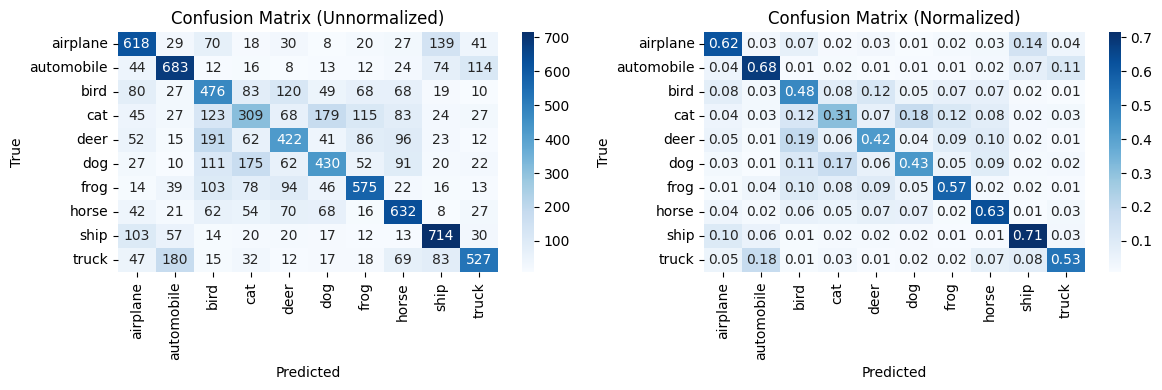


Randomly Select 10 Samples for Testing:


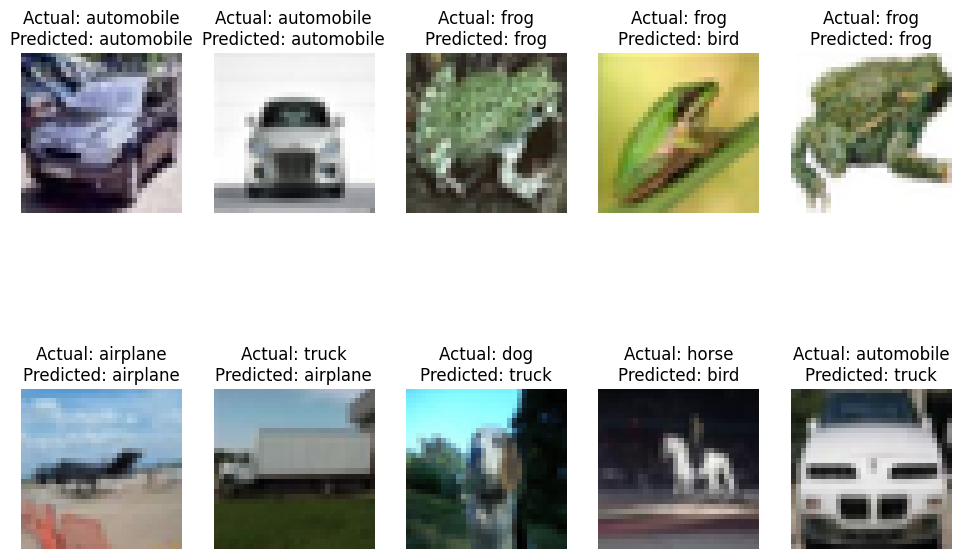

In [ ]:
if __name__ == "__main__":
    # CIFAR-10 input dimension
    input_dim = 3 * 32 * 32
    output_dim = 10

    # Define a list of hyperparameter configurations (cases)
    hyperparameter_cases = [
        {    'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256],
            'activations': [nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.01,
            'optimizer': 'SGD'
        },
        {
            'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256],
            'activations': [nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.01,
            'optimizer': 'adam'
        },
        {
            'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256],
            'activations': [nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.001,
            'optimizer': 'adam'
        },
        {
            'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256, 16],
            'activations': [nn.ReLU(), nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.01,
            'optimizer': 'adam'
        },
        {
            'batch_size' : 32,
             'num_epochs' : 10, # can increase it, but consumes more time
            'hidden_dims': [512, 256, 16],
            'activations': [nn.ReLU(), nn.ReLU(), nn.ReLU()],
            'learning_rate': 0.01,
            'optimizer': 'SGD'
        },
        # Add more cases here with different hyperparameters
    ]

    # Loop through the hyperparameter cases
    for case in hyperparameter_cases:
        print('='*80)
        print(case)
        print('='*80)

        batch_size = case['batch_size']
        num_epochs = case['num_epochs']
        hidden_dims = case['hidden_dims']
        activations = case['activations']
        learning_rate = case['learning_rate']
        optimizer_option = case['optimizer']

        main_(optimizer_option, batch_size, num_epochs, input_dim, hidden_dims, activations, output_dim, learning_rate)

**Comment: I tired using different number of epochs to increase the accuracy in all the departments. The problem came few times because it increased the execution time by alot in few optimizers like adam, it took longer than expected. I tried to play with learning rate also. I have taken the help from internet to make it more optimal**
**To increase the accuracy according to me was optimization was the hinderance. In that case decreasing the number of epochs was the best solution which I came across.**

## 6 Questions and exercises

### 6.1 Exercises (40 points)

E1. Using the original file and variables, discuss the overall results of the training. Overall, the system did not do well with an accuracy of just over 50% and the confusion matrices given above. In what situations did the system perform poorly or better? Is the system overfit or underfit? Give two approaches that might help improve system performance based on the results.

**Answer: According to the note book data, the accuracy of the training, validation, and test is 59.4475%, 52.78%, and 52.84%, respectively.  Indeed, with an accuracy of slightly over 50%, the system did not perform well.  The training accuracy rose by 75% as I raised the number of epochs, while the validation and test accuracies remained quite constant.  It appears that the model is becoming overfit.  Furthermore, the linear neural network models do not perform well on the CIFAR-10 dataset, which is a 2-D picture dataset.  In order to solve the issue, a variety of neural network models have been created, including models based on convolutional neural networks.  After reviewing the literature, I discovered a number of models that can demonstrate roughly 95% accuracy for the CIFAR-10 dataset.  The code scripts are available to us.**

**Since I am still learning the fundamentals of convolutional networks from the course lectures, I did not reflect on my experiments with these code scripts.  I experimented with using solely the FC linear neural network-based models in an attempt to obtain comparatively better outcomes.  The following hyperparameters can be adjusted: (i) the number of hidden layers; (ii) the dimensions of the hidden layers; (iii) the optimizer method with scheduling and weight_decay; (iv) batch normalization as a regularization; and (v) learning rate.**

E2. Implement one of your approaches in the code. Be sure to highlight what you did and describe it in words in this section. (you can change models, learning rates, optimization, add in regularization, train for different times,etc.) Comment on **why** you made each change. Give the setup that gave you the **best** results in your Python Notebook file with the run results saved.

**Answer: I have improved the code scripts (2a, 4a, and 5a above) to include a thorough hyperparameter tweaking technique after carrying out several trials.  This approach consists of optimizing (i) the number of hidden layers, (ii) the dimensions of the hidden layers, (iii) the optimizer method with scheduling and weight decay, (iv) the use of batch normalization as a regularization technique, and (v) the learning rate.  To iterate through different scenarios with different hyperparameter configurations, I have painstakingly written code scripts.**

 **For example, suppose that (i) 'hidden_dims' is [512, 256], (ii) 'activations' are defined as [ReLU(), ReLU()], (iii) 'learning_rate' is set to 0.01; (iv) 'optimizer' is 'SGD' with weight decay set to 5*10^4; and (v) a CosineAnnealingLR scheduler with T_max=200 is used.  Effectively, the 'weight_decay' attribute. After conducting multiple tests, I have enhanced the code scripts (2a, 4a, and 5a above) to incorporate a comprehensive hyperparameter tweaking technique.**

**In this method, (i) the number of hidden layers, (ii) the hidden layer dimensions, (iii) the optimizer method with scheduling and weight decay, (iv) the regularization technique of batch normalization, and (v) the learning rate are all optimized.**

**I have meticulously created code scripts to run through various scenarios with various hyperparameter configurations.   Take the following scenario, for instance: (i) 'hidden_dims' is [512, 256], (ii) 'activations' are specified as [ReLU(), ReLU()], (iii) 'learning_rate' is set to 0.01; (iv) 'optimizer' is 'SGD' with weight decay set to 5*10^4; and (v) a CosineAnnealingLR scheduler with T_max=200.   In practice, the 'weight_decay' property.**



E3. Compare the difference in the results obtained from two different optimizers. when might you choose one over the other, and why?

**Answer:Taking into account various network architectures and learning rates, I carefully compared the output from the Adam and SGD optimizers and discovered that SGD consistently performed better than the Adam optimizer.  Here is a brief synopsis of their traits:**

 **Stochastic Gradient Descent, or SGD, is simple to understand and apply.  It frequently performs exceptionally well, particularly when combined with appropriate learning rate scheduling.  When significant hyperparameter adjustment is needed or computing resources are restricted, it's a good option.**
 **Adam (Adaptive Moment Estimation): Adam is known for its strong performance on a variety of tasks and converges quickly.  For many applications, it can be a dependable default option, frequently removing the need for painstaking adjustment of learning rates and other hyperparameters.**

 **For CIFAR-10: Because of its size and complexity, CIFAR-10, which consists of 32x32 color images in 10 classes, poses particular difficulties.  Although SGD is initially preferred due to its high performance on these datasets, fine-tuning learning rates and hyperparameters is still necessary for optimization.  In conclusion, my tests have shown that SGD routinely outperforms Adam, even though Adam is a good default option for CIFAR-10.  Interestingly, linear fully connected models were ineffective for the 2-D image data from CIFAR-10, producing only about 50% accuracy.  In order to perhaps overcome the drawbacks of linear fully connected models, my next course of action will involve investigating convolutional networks, which are especially made for 2D image datasets like CIFAR-10**

### 6.2 Conceptual Questions: (10 Points)

C1. A “loss landscape” of your neural network’s loss function has a plateau shape, in
which there are large areas where the loss is flat. This means the gradient signal will be weak and gradient descent will not update the network parameters very much in each iteration.

What are two activation functions that may cause such a problem, and one activation function that will not?

**Answer: Tanh and Sigmoid are two activation functions that could result in a plateau-shaped loss landscape with diminishing gradients.  With gradients getting closer to zero input far from zero, the sigmoid compresses input into [0,1].  Tanh confines input to [-1, 1] with vanishing gradients in flat regions, just like Sigmoid.  On the other hand, this problem is less common using Rectified Linear Units (ReLU).  Although it occasionally runs into the "exploding gradient" issue, ReLU, max(0, x), is a preferred option for deep networks since it avoids vanishing gradients and maintains computational efficiency.**

C2. Which methods may help accelerate the optimization of a model that uses batch gradient descent?
a. Using Adam.
b. Fine tuning the learning rate using grid search.
c. Initializing all the weights to zero.
d. Using mini-batch gradient descent.

**Answer: When employing batch gradient descent, the choices a, b, and d can help speed up optimization; however, c is not advised.
Adam is an adaptive optimization algorithm that improves optimization efficiency by adapting learning rates per parameter and converges more quickly than conventional batch gradient descent techniques.  
Since modifying the learning rate is essential for neural network optimization,
in the case of (b), fine-tuning it with methods like grid search aids in determining an ideal learning rate, which can greatly accelerate convergence.  
In the situation of (d), mini-batch gradient descent uses smaller subsets of the data (mini-batches) to update model parameters more often than batch gradient descent.  It is a quicker and more effective optimization technique because of its parallelism and lower noise in gradient estimates.
It is not advised to initialize all weights in (c) to zero since this causes symmetry problems in neural networks, which impede convergence.  To prevent such issues, weight initialization methods such as Xavier/Glorot initialization are recommended.**





 C3. Compute the value of the function f(θ)=(θ-1)^4 after updating θ in one step of gradient descent, for θ = 4 and η=0.01. Does it look like the algorithm will converge to an optimum value of the function? Why or why not?

 **Answer:The function value following one step of gradient descent is roughly 13.58 after running the code snippet shown below for the specified values.  The initial condition and eta (learning rate) determine whether the algorithm will converge to an optimal value.  In our instance, we began with η=0.01 (small learning rate) and θ = 4.  We began at θ=4, and for the given function, a global minimum where f(θ) = 0 is at θ=1.  The algorithm is heading toward the minimum in the correct direction.  Gradient descent will eventually converge to the optimal value at θ = 1, where f(θ) = 0, if we keep updating θ in this way.**



In [ ]:
#Computation for the C3 question above
# Given values
theta_old = 4
eta = 0.01

# Compute the gradient of the function
gradient = theta_old * (theta_old - 1) ** 3

# Update theta
theta_new = theta_old - eta * gradient

# Compute the new function value
function_value = (theta_new - 1) ** 4

theta_new, function_value

(2.92, 13.589544959999998)

C4. Which statements are true about the step size in gradient descent?
a. The step size is the learning rate times the magnitude of the gradient.
b. If the step size is too big, gradient descent may oscillate leading to slow or unstable convergence.
c. The smaller the step size, the faster we can reach the optimal minima.

**Answer: Both (a) and (b) are True.**

C5. State if each statement is true or false and give a brief reason

A). L2 regularization encourages sparse weights.

B) You notice that while training your neural network the test loss initially decreases
but then starts increasing, while training loss continues to decrease. This means
that test loss will only continue to increase if we train further.

** Answer: A). Sparse weights are encouraged by L2 regularization.**

 **B) You see that when you train your neural network, the training loss keeps going down while the test loss first goes down and then starts to go up.  This implies that as we train more, test loss will just keep rising.**

 Response:

 **A) False.  Instead of sparse weights, L2 regularization promotes weight values that are tiny but not zero.**

**B) True.  Overfitting is suggested by increasing test loss as training loss falls, and generalization is expected to get worse as training goes on.**